In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

2024-05-19 19:59:49.540835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ticker = 'AAPL'
df = yf.download(ticker)
open_values = df.iloc[:, 0:1].values
len(open_values)

[*********************100%%**********************]  1 of 1 completed


10949

In [3]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0,1))
open_values = mms.fit_transform(open_values)
open_values

array([[3.97448390e-04],
       [3.66443799e-04],
       [3.21341048e-04],
       ...,
       [9.48931741e-01],
       [9.61862958e-01],
       [9.57013713e-01]])

In [4]:
X_train = []
y_train = []
marker = int(.8 * len(open_values))
for i in range(100, marker):
  X_train.append(open_values[i-100:i, 0])
  y_train.append(open_values[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# change it to a 3D tensor

X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1], 1])
X_train.shape

(8659, 100, 1)

In [5]:
class GRU():
  def __init__(self, x_train, y_train):
    self.x_train = x_train
    self.y_train = y_train
    self.model = None
  
  def check(self):
    return self.model.summary

  def create_model(self):
    model = tf.keras.models.Sequential(
      layers=[
        tf.keras.layers.Input(shape=[X_train.shape[1], X_train.shape[2]]),
        tf.keras.layers.GRU(units=50, return_sequences=True),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.GRU(units=50, return_sequences=True),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.GRU(units=50, return_sequences=True),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.GRU(units=50),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(units=1),
      ]
    )

    self.model = model
  
  def compile(self):
    self.model.compile(optimizer='adam', loss='mean_squared_error')
    self.model.fit(self.x_train, self.y_train, batch_size=int(.07 * len(self.x_train)), epochs=3)
  
  def predict(self, x_test):
    return self.model.predict(x_test)

In [6]:
model = GRU(X_train, y_train)
model.create_model()
model.compile()

2024-05-19 19:59:54.798227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
15/15 [==============================] - 9s 367ms/step - loss: 5.4129e-04
Epoch 2/3
15/15 [==============================] - 6s 386ms/step - loss: 8.6517e-05
Epoch 3/3
15/15 [==============================] - 5s 348ms/step - loss: 3.8719e-05


In [12]:
X_test = []
y_truth = []

dataset_total = df['Open']
inputs = dataset_total.values
inputs = inputs.reshape(-1, 1)
inputs = mms.transform(inputs)

for i in range(marker, len(dataset_total)):
  X_test.append(inputs[i-100:i, 0])
  y_truth.append(inputs[i, 0])


X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_truth = np.array(y_truth).reshape(-1, 1) 
predicted_stock_price = model.predict(X_test)
predicted_stock_price = mms.inverse_transform(predicted_stock_price)
y_truth = mms.inverse_transform(y_truth)

69/69 [==============================] - 2s 23ms/step


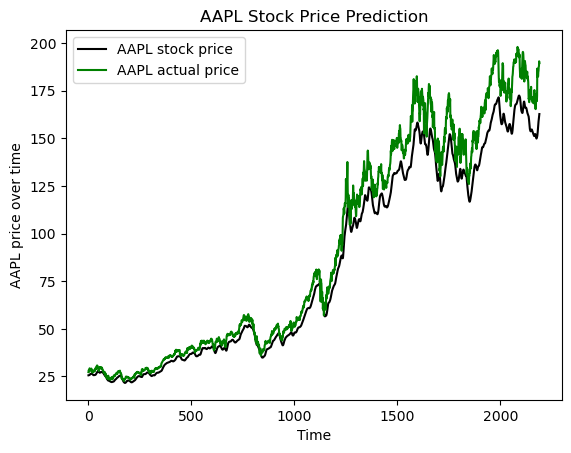

AAPL_stock_plot_gru.png


In [10]:
import os

plt.plot(predicted_stock_price, color = 'black', label = f'{ticker} stock price')
plt.plot(y_truth, color = 'green', label = f'{ticker} actual price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{ticker} price over time')
plt.legend()

image_path = os.path.join(f'{ticker}_stock_plot_gru.png')

plt.savefig(image_path)
plt.show()
plt.close()
print(image_path)


In [11]:
from sklearn.metrics import r2_score
r2 = r2_score(y_truth, predicted_stock_price)
print(r2)

0.9559755341651923


In [14]:
print(len(X_test))

2190
